In [18]:
import io
import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import math
import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [19]:
conjuntos = ['treinamento', 'teste', 'validacao']
base_path = 'dados/processed'
pastas_excluir = ['cleanImage', '?']

for conjunto in conjuntos:
    conjunto_path = os.path.join(base_path, conjunto)
    for nome in os.listdir(conjunto_path):
        full_path = os.path.join(conjunto_path, nome)
        if nome in pastas_excluir and os.path.isdir(full_path):
            print(f"Removendo pasta: {full_path}")
            shutil.rmtree(full_path)

In [20]:
train_dir = 'dados/processed/treinamento'
val_dir   = 'dados/processed/validacao'
test_dir  = 'dados/processed/teste'

In [21]:
def load_images_from_folder(folder):
    images = {}
    for char_folder in os.listdir(folder):
        char_images = []
        for filename in os.listdir(os.path.join(folder, char_folder)):
            if filename.endswith('.jpg'):
                img_path = os.path.join(folder, char_folder, filename)
                if os.path.isfile(img_path):
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    original_img_name = filename.split('_')[0] if '_' in filename else filename
                    if img is not None:
                        char_images.append((img, original_img_name))
        
        images[char_folder] = char_images
    
    return images

In [22]:
def calculate_bin_index(angle):
    temp = (angle / 20.0) - 0.5
    j = math.floor(temp)
    return j

def calculate_center_of_bin(j):
    return round((j + 0.5) * 20.0, 9)

def calculate_value_of_bin(magnitude, angle, j):
    cj = calculate_center_of_bin(j)
    vj = magnitude * ((cj - angle) / 20.0)
    return round(vj, 9)

In [23]:
def compute_histogram(magnitude, angle, num_bins=9):
    histogram = np.zeros(num_bins)
    bin_size = 180 / num_bins

    bin_index = angle / bin_size
    lower = int(np.floor(bin_index)) % num_bins
    upper = (lower + 1) % num_bins
    ratio = bin_index - lower

    histogram[lower] += magnitude * (1 - ratio)
    histogram[upper] += magnitude * ratio

    return histogram

In [24]:
# def extract_hog_features(image):
#     resized_image = cv2.resize(image, (64, 128))

#     hog = cv2.HOGDescriptor()
#     features = hog.compute(resized_image)
#     if features is None:
#         print("Erro ao extrair características HOG: 'features' é None")
#         return np.array([])
#     # print(f"Dimensões das características HOG: {features.shape}")
#     return np.array(features)

def extract_hog_features(image, cell_size=8, block_size=2, num_bins=9):
    # Redimensiona para o tamanho padrão usado em HOG
    resized_image = cv2.resize(image, (64, 128))

    # Calcula os gradientes usando Sobel
    Gx = cv2.Sobel(resized_image, cv2.CV_64F, 1, 0, ksize=3)
    Gy = cv2.Sobel(resized_image, cv2.CV_64F, 0, 1, ksize=3)

    # Calcula magnitude e ângulo
    magnitude = np.sqrt(Gx ** 2 + Gy ** 2)
    angle = np.arctan2(Gy, Gx) * (180 / np.pi)
    angle[angle < 0] += 180
    angle[angle >= 180] -= 180

    nrows, ncols = magnitude.shape

    # Organiza células
    hog_cells = []
    for i in range(0, nrows, cell_size):
        row_cells = []
        for j in range(0, ncols, cell_size):
            hist = np.zeros(num_bins)
            for dx in range(min(cell_size, nrows - i)):
                for dy in range(min(cell_size, ncols - j)):
                    if i + dx < nrows and j + dy < ncols:
                        mag = magnitude[i + dx, j + dy]
                        ang = angle[i + dx, j + dy]
                        hist += compute_histogram(mag, ang, num_bins)
            row_cells.append(hist)
        if row_cells:
            hog_cells.append(row_cells)

    # Extrai características por blocos e normaliza
    features = []
    epsilon = 1e-5
    
    # Verifica se temos células suficientes para formar blocos
    if len(hog_cells) < block_size or len(hog_cells[0]) < block_size:
        # Retorna um vetor de características vazio ou com um valor padrão
        print(f"Aviso: Imagem muito pequena para extração HOG com os parâmetros atuais.")
        return np.zeros(36, dtype=np.float32)  # Retorna vetor de zeros como fallback
        
    for i in range(len(hog_cells) - block_size + 1):
        for j in range(len(hog_cells[0]) - block_size + 1):
            # Concatena as células em um bloco
            block = []
            for bi in range(block_size):
                for bj in range(block_size):
                    block.append(hog_cells[i + bi][j + bj])
            
            block_features = np.concatenate(block)
            # Normalização L2
            norm = np.sqrt(np.sum(block_features ** 2) + epsilon)
            features.extend(block_features / norm)

    return np.array(features, dtype=np.float32)

    # Normalização L2
    # hog_features = np.array(hog_features)
    # norm = np.linalg.norm(hog_features) + 1e-7
    # hog_features = hog_features / norm
    # return hog_features.tolist()

In [28]:
def create_features_df(folder, min_samples_per_class=50):
    if os.path.exists(f'{folder}_features.csv'):
        print(f"Arquivo {folder}_features.csv já existe. Carregando...")
        return pd.read_csv(f'{folder}_features.csv')
    
    print(f"Extraindo HOG features de {folder}...")
    features = []
    images = load_images_from_folder(folder)
        
    for char, char_images in tqdm(images.items(), desc="Processando caracteres"):
        print(f"Processando imagens do caractere: {char}")
        
        for (img, name) in char_images:
            hog_features = extract_hog_features(img)
            features.append([str(char)] + [str(name)] + hog_features.tolist())
            
    df = pd.DataFrame(features)
    df.columns = ['label'] + ['original_image'] + [f'feature_{i}' for i in range(len(df.columns) - 2)]

    df.to_csv(f'{folder}_features.csv', index=False)
    
    return df

In [29]:
df_train = create_features_df(train_dir)
df_val = create_features_df(val_dir)
df_test = create_features_df(test_dir)

# Usando data augmentation (descomente para usar)
# df_train = create_features_df(train_dir, use_augmentation=True, min_samples_per_class=50)
# df_val = create_features_df(val_dir, use_augmentation=True, min_samples_per_class=50)
# df_test = create_features_df(test_dir, use_augmentation=True, min_samples_per_class=50)

Extraindo HOG features de dados/processed/treinamento...


Processando caracteres:   0%|          | 0/36 [00:00<?, ?it/s]

Processando imagens do caractere: D


Processando caracteres:   3%|▎         | 1/36 [00:18<10:37, 18.20s/it]

Processando imagens do caractere: 6


Processando caracteres:   6%|▌         | 2/36 [00:37<10:38, 18.77s/it]

Processando imagens do caractere: U


Processando caracteres:   8%|▊         | 3/36 [00:57<10:35, 19.27s/it]

Processando imagens do caractere: M


Processando caracteres:  11%|█         | 4/36 [01:17<10:25, 19.55s/it]

Processando imagens do caractere: A


Processando caracteres:  14%|█▍        | 5/36 [01:35<09:51, 19.08s/it]

Processando imagens do caractere: L


Processando caracteres:  17%|█▋        | 6/36 [01:54<09:33, 19.13s/it]

Processando imagens do caractere: K


Processando caracteres:  19%|█▉        | 7/36 [02:13<09:13, 19.07s/it]

Processando imagens do caractere: 0


Processando caracteres:  22%|██▏       | 8/36 [02:31<08:39, 18.54s/it]

Processando imagens do caractere: S


Processando caracteres:  25%|██▌       | 9/36 [02:51<08:33, 19.00s/it]

Processando imagens do caractere: 9


Processando caracteres:  28%|██▊       | 10/36 [03:09<08:11, 18.91s/it]

Processando imagens do caractere: 1


Processando caracteres:  31%|███       | 11/36 [03:30<08:06, 19.45s/it]

Processando imagens do caractere: Z


Processando caracteres:  33%|███▎      | 12/36 [03:49<07:47, 19.47s/it]

Processando imagens do caractere: V


Processando caracteres:  36%|███▌      | 13/36 [04:11<07:38, 19.95s/it]

Processando imagens do caractere: E


Processando caracteres:  39%|███▉      | 14/36 [04:29<07:10, 19.57s/it]

Processando imagens do caractere: 8


Processando caracteres:  42%|████▏     | 15/36 [04:48<06:47, 19.43s/it]

Processando imagens do caractere: 4


Processando caracteres:  44%|████▍     | 16/36 [05:07<06:26, 19.33s/it]

Processando imagens do caractere: N


Processando caracteres:  47%|████▋     | 17/36 [05:27<06:06, 19.27s/it]

Processando imagens do caractere: O


Processando caracteres:  50%|█████     | 18/36 [05:48<05:58, 19.92s/it]

Processando imagens do caractere: 5


Processando caracteres:  53%|█████▎    | 19/36 [06:08<05:36, 19.82s/it]

Processando imagens do caractere: F


Processando caracteres:  56%|█████▌    | 20/36 [06:28<05:18, 19.88s/it]

Processando imagens do caractere: C


Processando caracteres:  58%|█████▊    | 21/36 [06:47<04:54, 19.63s/it]

Processando imagens do caractere: T


Processando caracteres:  61%|██████    | 22/36 [07:05<04:30, 19.29s/it]

Processando imagens do caractere: 2


Processando caracteres:  64%|██████▍   | 23/36 [07:25<04:12, 19.41s/it]

Processando imagens do caractere: W


Processando caracteres:  67%|██████▋   | 24/36 [07:45<03:54, 19.58s/it]

Processando imagens do caractere: 7


Processando caracteres:  69%|██████▉   | 25/36 [08:04<03:32, 19.34s/it]

Processando imagens do caractere: I


Processando caracteres:  72%|███████▏  | 26/36 [08:22<03:10, 19.00s/it]

Processando imagens do caractere: H


Processando caracteres:  75%|███████▌  | 27/36 [08:41<02:50, 19.00s/it]

Processando imagens do caractere: G


Processando caracteres:  78%|███████▊  | 28/36 [09:01<02:35, 19.44s/it]

Processando imagens do caractere: J


Processando caracteres:  81%|████████  | 29/36 [09:19<02:12, 18.99s/it]

Processando imagens do caractere: Y


Processando caracteres:  83%|████████▎ | 30/36 [09:40<01:57, 19.50s/it]

Processando imagens do caractere: 3


Processando caracteres:  86%|████████▌ | 31/36 [09:58<01:35, 19.15s/it]

Processando imagens do caractere: R


Processando caracteres:  89%|████████▉ | 32/36 [10:17<01:16, 19.01s/it]

Processando imagens do caractere: P


Processando caracteres:  92%|█████████▏| 33/36 [10:35<00:56, 18.82s/it]

Processando imagens do caractere: B


Processando caracteres:  94%|█████████▍| 34/36 [10:53<00:36, 18.43s/it]

Processando imagens do caractere: X


Processando caracteres:  97%|█████████▋| 35/36 [11:11<00:18, 18.42s/it]

Processando imagens do caractere: Q


Processando caracteres: 100%|██████████| 36/36 [11:30<00:00, 19.19s/it]


Extraindo HOG features de dados/processed/validacao...


Processando caracteres:   0%|          | 0/36 [00:00<?, ?it/s]

Processando imagens do caractere: D


Processando caracteres:   3%|▎         | 1/36 [00:02<01:29,  2.55s/it]

Processando imagens do caractere: 6


Processando caracteres:   6%|▌         | 2/36 [00:04<01:24,  2.48s/it]

Processando imagens do caractere: U


Processando caracteres:   8%|▊         | 3/36 [00:07<01:24,  2.57s/it]

Processando imagens do caractere: M


Processando caracteres:  11%|█         | 4/36 [00:09<01:18,  2.46s/it]

Processando imagens do caractere: A


Processando caracteres:  14%|█▍        | 5/36 [00:12<01:11,  2.32s/it]

Processando imagens do caractere: L


Processando caracteres:  17%|█▋        | 6/36 [00:14<01:08,  2.29s/it]

Processando imagens do caractere: K


Processando caracteres:  19%|█▉        | 7/36 [00:16<01:05,  2.27s/it]

Processando imagens do caractere: 0


Processando caracteres:  22%|██▏       | 8/36 [00:19<01:05,  2.35s/it]

Processando imagens do caractere: S


Processando caracteres:  25%|██▌       | 9/36 [00:21<01:06,  2.47s/it]

Processando imagens do caractere: 9


Processando caracteres:  28%|██▊       | 10/36 [00:23<01:01,  2.35s/it]

Processando imagens do caractere: 1


Processando caracteres:  31%|███       | 11/36 [00:26<01:01,  2.48s/it]

Processando imagens do caractere: Z


Processando caracteres:  33%|███▎      | 12/36 [00:28<00:55,  2.31s/it]

Processando imagens do caractere: V


Processando caracteres:  36%|███▌      | 13/36 [00:30<00:52,  2.27s/it]

Processando imagens do caractere: E


Processando caracteres:  39%|███▉      | 14/36 [00:32<00:49,  2.27s/it]

Processando imagens do caractere: 8


Processando caracteres:  42%|████▏     | 15/36 [00:35<00:48,  2.29s/it]

Processando imagens do caractere: 4


Processando caracteres:  44%|████▍     | 16/36 [00:37<00:44,  2.23s/it]

Processando imagens do caractere: N


Processando caracteres:  47%|████▋     | 17/36 [00:39<00:44,  2.33s/it]

Processando imagens do caractere: O


Processando caracteres:  50%|█████     | 18/36 [00:42<00:45,  2.52s/it]

Processando imagens do caractere: 5


Processando caracteres:  53%|█████▎    | 19/36 [00:45<00:42,  2.52s/it]

Processando imagens do caractere: F


Processando caracteres:  56%|█████▌    | 20/36 [00:48<00:40,  2.54s/it]

Processando imagens do caractere: C


Processando caracteres:  58%|█████▊    | 21/36 [00:50<00:36,  2.46s/it]

Processando imagens do caractere: T


Processando caracteres:  61%|██████    | 22/36 [00:52<00:32,  2.32s/it]

Processando imagens do caractere: 2


Processando caracteres:  64%|██████▍   | 23/36 [00:54<00:29,  2.30s/it]

Processando imagens do caractere: W


Processando caracteres:  67%|██████▋   | 24/36 [00:56<00:27,  2.27s/it]

Processando imagens do caractere: 7


Processando caracteres:  69%|██████▉   | 25/36 [00:59<00:26,  2.38s/it]

Processando imagens do caractere: I


Processando caracteres:  72%|███████▏  | 26/36 [01:01<00:24,  2.43s/it]

Processando imagens do caractere: H


Processando caracteres:  75%|███████▌  | 27/36 [01:04<00:21,  2.44s/it]

Processando imagens do caractere: G


Processando caracteres:  78%|███████▊  | 28/36 [01:07<00:20,  2.57s/it]

Processando imagens do caractere: J


Processando caracteres:  81%|████████  | 29/36 [01:10<00:18,  2.66s/it]

Processando imagens do caractere: Y


Processando caracteres:  83%|████████▎ | 30/36 [01:12<00:15,  2.65s/it]

Processando imagens do caractere: 3


Processando caracteres:  86%|████████▌ | 31/36 [01:15<00:12,  2.52s/it]

Processando imagens do caractere: R


Processando caracteres:  89%|████████▉ | 32/36 [01:17<00:09,  2.48s/it]

Processando imagens do caractere: P


Processando caracteres:  92%|█████████▏| 33/36 [01:20<00:07,  2.54s/it]

Processando imagens do caractere: B


Processando caracteres:  94%|█████████▍| 34/36 [01:22<00:05,  2.54s/it]

Processando imagens do caractere: X


Processando caracteres:  97%|█████████▋| 35/36 [01:25<00:02,  2.68s/it]

Processando imagens do caractere: Q


Processando caracteres: 100%|██████████| 36/36 [01:27<00:00,  2.44s/it]


Extraindo HOG features de dados/processed/teste...


Processando caracteres:   0%|          | 0/36 [00:00<?, ?it/s]

Processando imagens do caractere: D


Processando caracteres:   3%|▎         | 1/36 [00:02<01:38,  2.80s/it]

Processando imagens do caractere: 6


Processando caracteres:   6%|▌         | 2/36 [00:05<01:23,  2.45s/it]

Processando imagens do caractere: U


Processando caracteres:   8%|▊         | 3/36 [00:07<01:23,  2.52s/it]

Processando imagens do caractere: M


Processando caracteres:  11%|█         | 4/36 [00:09<01:18,  2.44s/it]

Processando imagens do caractere: A


Processando caracteres:  14%|█▍        | 5/36 [00:12<01:13,  2.37s/it]

Processando imagens do caractere: L


Processando caracteres:  17%|█▋        | 6/36 [00:14<01:08,  2.30s/it]

Processando imagens do caractere: K


Processando caracteres:  19%|█▉        | 7/36 [00:16<01:06,  2.29s/it]

Processando imagens do caractere: 0


Processando caracteres:  22%|██▏       | 8/36 [00:19<01:05,  2.33s/it]

Processando imagens do caractere: S


Processando caracteres:  25%|██▌       | 9/36 [00:21<01:02,  2.33s/it]

Processando imagens do caractere: 9


Processando caracteres:  28%|██▊       | 10/36 [00:23<01:01,  2.37s/it]

Processando imagens do caractere: 1


Processando caracteres:  31%|███       | 11/36 [00:26<01:02,  2.50s/it]

Processando imagens do caractere: Z


Processando caracteres:  33%|███▎      | 12/36 [00:29<01:00,  2.53s/it]

Processando imagens do caractere: V


Processando caracteres:  36%|███▌      | 13/36 [00:31<00:58,  2.54s/it]

Processando imagens do caractere: E


Processando caracteres:  39%|███▉      | 14/36 [00:34<00:56,  2.55s/it]

Processando imagens do caractere: 8


Processando caracteres:  42%|████▏     | 15/36 [00:36<00:50,  2.42s/it]

Processando imagens do caractere: 4


Processando caracteres:  44%|████▍     | 16/36 [00:38<00:47,  2.37s/it]

Processando imagens do caractere: N


Processando caracteres:  47%|████▋     | 17/36 [00:41<00:48,  2.55s/it]

Processando imagens do caractere: O


Processando caracteres:  50%|█████     | 18/36 [00:44<00:49,  2.74s/it]

Processando imagens do caractere: 5


Processando caracteres:  53%|█████▎    | 19/36 [00:47<00:44,  2.63s/it]

Processando imagens do caractere: F


Processando caracteres:  56%|█████▌    | 20/36 [00:49<00:39,  2.48s/it]

Processando imagens do caractere: C


Processando caracteres:  58%|█████▊    | 21/36 [00:51<00:36,  2.44s/it]

Processando imagens do caractere: T


Processando caracteres:  61%|██████    | 22/36 [00:53<00:32,  2.33s/it]

Processando imagens do caractere: 2


Processando caracteres:  64%|██████▍   | 23/36 [00:56<00:30,  2.34s/it]

Processando imagens do caractere: W


Processando caracteres:  67%|██████▋   | 24/36 [00:58<00:29,  2.49s/it]

Processando imagens do caractere: 7


Processando caracteres:  69%|██████▉   | 25/36 [01:01<00:27,  2.50s/it]

Processando imagens do caractere: I


Processando caracteres:  72%|███████▏  | 26/36 [01:04<00:25,  2.54s/it]

Processando imagens do caractere: H


Processando caracteres:  75%|███████▌  | 27/36 [01:06<00:22,  2.50s/it]

Processando imagens do caractere: G


Processando caracteres:  78%|███████▊  | 28/36 [01:08<00:19,  2.47s/it]

Processando imagens do caractere: J


Processando caracteres:  81%|████████  | 29/36 [01:10<00:16,  2.33s/it]

Processando imagens do caractere: Y


Processando caracteres:  83%|████████▎ | 30/36 [01:13<00:13,  2.33s/it]

Processando imagens do caractere: 3


Processando caracteres:  86%|████████▌ | 31/36 [01:15<00:11,  2.30s/it]

Processando imagens do caractere: R


Processando caracteres:  89%|████████▉ | 32/36 [01:18<00:09,  2.41s/it]

Processando imagens do caractere: P


Processando caracteres:  92%|█████████▏| 33/36 [01:20<00:07,  2.45s/it]

Processando imagens do caractere: B


Processando caracteres:  94%|█████████▍| 34/36 [01:22<00:04,  2.36s/it]

Processando imagens do caractere: X


Processando caracteres:  97%|█████████▋| 35/36 [01:25<00:02,  2.49s/it]

Processando imagens do caractere: Q


Processando caracteres: 100%|██████████| 36/36 [01:28<00:00,  2.45s/it]


In [32]:
df_test[df_test['original_image'] == '009001']

,label,original_image,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_3770,feature_3771,feature_3772,feature_3773,feature_3774,feature_3775,feature_3776,feature_3777,feature_3778,feature_3779
1941,Z,009001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002272,0.002615,0.002272,0.004133,0.010154,0.005973,0.005920,0.004404,0.007191,0.003321
2628,4,009001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3286,F,009001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3557,C,009001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.092752,0.066559,0.022838,0.033242,0.021530,0.014327,0.000000,0.008310,0.024931,0.022838
4006,W,009001,0.212426,0.130196,0.126892,0.110733,0.181362,0.221279,0.117677,0.137009,...,0.001327,0.000128,0.000000,0.001094,0.002274,0.007720,0.006784,0.005548,0.006157,0.001503
4828,J,009001,0.005325,0.000785,0.000548,0.000517,0.002006,0.002802,0.001974,0.002502,...,0.000514,0.000682,0.001542,0.000679,0.000942,0.001556,0.001395,0.001468,0.001452,0.000489


In [33]:
df_train['label'] = df_train['label'].astype(str)
df_val['label'] = df_val['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)

In [38]:
X_train = df_train.drop(columns=['label', 'original_image'])

labels = sorted(df_train['label'].unique())
dict_labels = {label: idx for idx, label in enumerate(labels)}
y_train = df_train['label']
X_val = df_val.drop(columns=['label', 'original_image'])
y_val = df_val['label']
X_test = df_test.drop(columns=['label', 'original_image'])
y_test = df_test['label']
y_original_images = df_test['original_image']

# Normalizando os dados (importante para SVM e MLP)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Garantindo que todos os dados são numéricos
X_train_scaled = np.asarray(X_train_scaled, dtype=np.float32)
X_val_scaled = np.asarray(X_val_scaled, dtype=np.float32)
X_test_scaled = np.asarray(X_test_scaled, dtype=np.float32)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

In [39]:
print(f'Different types in X_train: {X_train.dtypes.unique()}')
print(f'Different types in y_train: {y_train}')

Different types in X_train: [dtype('float64')]
Different types in y_train: 0        D
1        D
2        D
3        D
4        D
        ..
47863    Q
47864    Q
47865    Q
47866    Q
47867    Q
Name: label, Length: 47868, dtype: object


Treinando RandomForestClassifier...
Acurácia - Treinamento (RandomForestClassifier): 1.0
Acurácia - Validação (RandomForestClassifier): 0.7744411077744411
Acurácia - Teste (RandomForestClassifier): 0.7824491157824491
Relatório de Classificação - Teste (RandomForestClassifier):
              precision    recall  f1-score   support

           0       0.92      0.68      0.78       177
           1       0.73      0.79      0.76       170
           2       0.76      0.90      0.82       162
           3       0.74      0.85      0.79       163
           4       0.91      0.96      0.93       160
           5       0.75      0.72      0.74       167
           6       0.66      0.79      0.72       161
           7       0.91      0.78      0.84       156
           8       0.72      0.71      0.72       154
           9       0.87      0.85      0.86       172
           A       0.92      0.94      0.93       161
           B       0.69      0.73      0.71       148
           C       

<Figure size 800x800 with 0 Axes>

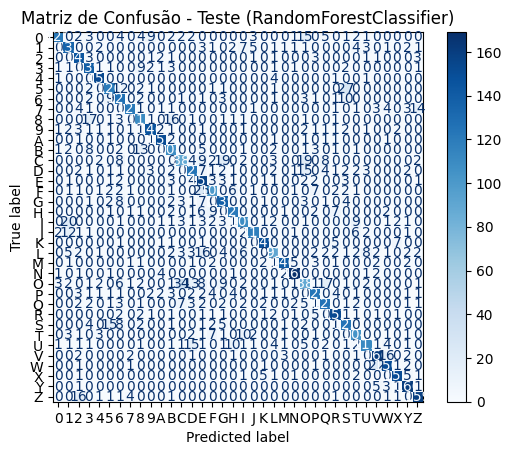

Treinando XGBClassifier...


/home/rafael-gomes/Desktop/others/TP2-ICV/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:18:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grids = {
    RandomForestClassifier: {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
    },
    XGBClassifier: {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
    },
    # DecisionTreeClassifier: {
    #     'max_depth': [None, 10, 20, 30],
    #     'min_samples_split': [2, 5, 10],
    # },
    # KNeighborsClassifier: {
    #     'n_neighbors': [3, 5, 7],
    #     'weights': ['uniform', 'distance'],
    # },
    SVC: {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.01, 0.1],
        'kernel': ['rbf', 'poly', 'sigmoid']
    }
}

models = [
    RandomForestClassifier(random_state=42),
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
    # DecisionTreeClassifier(random_state=42),
    # # MLPClassifier(random_state=42, max_iter=500),
    # KNeighborsClassifier(),
    # SVC(random_state=42)
]

results = {}

for model in models:
    print(f"Treinando {model.__class__.__name__}...")
    # Usando os dados normalizados para o treinamento
    if isinstance(model, XGBClassifier):
        model.fit(X_train_scaled, y_train_encoded, eval_set=[(X_val_scaled, y_val_encoded)], verbose=False)
        
        # Previsões com dados codificados
        y_pred_train_encoded = model.predict(X_train_scaled)
        y_pred_val_encoded = model.predict(X_val_scaled)
        y_pred_test_encoded = model.predict(X_test_scaled)
        
        # Converta as previsões de volta para as classes originais
        y_pred_train = label_encoder.inverse_transform(y_pred_train_encoded)
        y_pred_val = label_encoder.inverse_transform(y_pred_val_encoded)
        y_pred_test = label_encoder.inverse_transform(y_pred_test_encoded)
        
        train_acc = np.mean(y_pred_train == y_train)
        val_acc = np.mean(y_pred_val == y_val)
        test_acc = np.mean(y_pred_test == y_test)
    
    else:
        model.fit(X_train_scaled, y_train)
        
        # Avaliação nos conjuntos de treinamento, validação e teste (usando dados normalizados)
        y_pred_train = model.predict(X_train_scaled)
        y_pred_val = model.predict(X_val_scaled)
        y_pred_test = model.predict(X_test_scaled)

        train_acc = model.score(X_train_scaled, y_train)
        val_acc = model.score(X_val_scaled, y_val)
        test_acc = model.score(X_test_scaled, y_test)
    
    print(f"Acurácia - Treinamento ({model.__class__.__name__}):", train_acc)
    print(f"Acurácia - Validação ({model.__class__.__name__}):", val_acc)
    print(f"Acurácia - Teste ({model.__class__.__name__}):", test_acc)
    
    print(f"Relatório de Classificação - Teste ({model.__class__.__name__}):") 
    print(classification_report(y_test, y_pred_test))
    
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Matriz de Confusão - Teste ({model.__class__.__name__})")
    plt.show()
    
    # Armazenar resultados para comparação
    results[model.__class__.__name__] = {
        'train_acc': train_acc,
        'val_acc': val_acc,
        'test_acc': test_acc,
        'model': model
    }

In [ ]:
# # Vamos realizar a busca por hiperparâmetros para o melhor modelo (ajuste conforme necessidade)
# best_model_name = max(results, key=lambda k: results[k]['test_acc'])
# print(f"Melhor modelo: {best_model_name} com acurácia de teste: {results[best_model_name]['test_acc']:.4f}")

# # Inicializa o modelo para grid search
# if best_model_name == 'SVC':
#     grid_model = SVC(probability=True, random_state=42)
#     param_grid = {
#         'C': [0.1, 1, 10, 100],
#         'gamma': ['scale', 'auto', 0.01, 0.1, 1],
#         'kernel': ['rbf', 'poly', 'sigmoid'],
#         'degree': [2, 3, 4] # para o kernel 'poly'
#     }
# else:
#     # Use o modelo correspondente e seus parâmetros
#     for model_class in param_grids.keys():
#         if model_class.__name__ == best_model_name:
#             grid_model = model_class(random_state=42 if 'random_state' in model_class().get_params() else None)
#             param_grid = param_grids[model_class]
#             break

# print(f"Executando GridSearchCV para {best_model_name}...")
# grid = GridSearchCV(grid_model, param_grid, cv=3, n_jobs=-1, scoring='accuracy')
# grid.fit(X_train_scaled, y_train)

# print(f"Melhores parâmetros: {grid.best_params_}")
# print(f"Melhor pontuação: {grid.best_score_:.4f}")

# # Testando o modelo otimizado
# best_model = grid.best_estimator_
# y_pred_test = best_model.predict(X_test_scaled)
# test_acc = best_model.score(X_test_scaled, y_test)

# print(f"Acurácia no conjunto de teste com o modelo otimizado: {test_acc:.4f}")
# print(f"Relatório de classificação:")
# print(classification_report(y_test, y_pred_test))

# # Visualizando a matriz de confusão
# cm = confusion_matrix(y_test, y_pred_test)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
# disp.plot(cmap=plt.cm.Blues)
# plt.title(f"Matriz de Confusão - Modelo Otimizado ({best_model_name})")
# plt.show()

Melhor modelo: RandomForestClassifier com acurácia de teste: 0.7824
Executando GridSearchCV para RandomForestClassifier...


/home/rafael-gomes/Desktop/others/TP2-ICV/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/home/rafael-gomes/Desktop/others/TP2-ICV/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/home/rafael-gomes/Desktop/others/TP2-ICV/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/home/rafael-gomes/Desktop/others/TP2-ICV/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/home/rafael-gomes/Desktop/others/TP2-ICV/.venv/lib/

KeyboardInterrupt: 

In [ ]:
def Get_Accuracy_per_size(y_true,y_pred):
        prev =(y_pred == y_true)
        PM_1 = 0
        PM_2 = 0
        PM_3 = 0
        PM_4 = 0
        PM_5 = 0
        PM_6 = 0
        for i in range(0,len(prev),6):
            acertos = 0
            for j in range(6):
                if prev[i+j]:
                    acertos = acertos + 1
                    
            if(acertos == 6):
                PM_1 = PM_1 + 1
                PM_2 = PM_2 + 1
                PM_3 = PM_3 + 1
                PM_4 = PM_4 + 1
                PM_5 = PM_5 + 1
                PM_6 = PM_6 + 1
                
            if(acertos == 5):
                PM_1 = PM_1 + 1
                PM_2 = PM_2 + 1
                PM_3 = PM_3 + 1
                PM_4 = PM_4 + 1
                PM_5 = PM_5 + 1
            
            if(acertos == 4):
                PM_1 = PM_1 + 1
                PM_2 = PM_2 + 1
                PM_3 = PM_3 + 1
                PM_4 = PM_4 + 1
                
            if(acertos == 3):
                PM_1 = PM_1 + 1
                PM_2 = PM_2 + 1
                PM_3 = PM_3 + 1
                
            if(acertos == 2):
                PM_1 = PM_1 + 1
                PM_2 = PM_2 + 1
                
            if(acertos == 1):
                PM_1 = PM_1 + 1
                
        size = (len(prev)/6)
        y = [(PM_1/size),(PM_2/size),(PM_3/size),(PM_4/size),(PM_5/size),(PM_6/size)]
        x = [1,2,3,4,5,6]
        
        plt.figure(figsize=(14, 5)) 
        plt.plot(x, y, color="Blue", linewidth=2, marker='o', markersize=8)
        
        plt.grid(True, alpha=0.6)
        plt.gca().spines['top'].set_linewidth(0)
        plt.gca().spines['bottom'].set_linewidth(0.4)
        plt.gca().spines['left'].set_linewidth(0.4)
        plt.gca().spines['right'].set_linewidth(0)
        
        plt.xlabel("\nNúmero mínimo de caracteres reconhecidos por captcha", fontsize=9)
        plt.ylabel("Taxa de Reconhecimento\n", fontsize=9)
        plt.xticks(fontsize=9)
        plt.yticks(fontsize=9)

        plt.title("Resultado HOG \n\n", fontsize=10)
        plt.gca().set_axisbelow(True)

        name = "Acertos_por_quantidade_HOG"
        save_path = os.path.join('dados/resultados', name + ".png")
        plt.savefig(save_path, bbox_inches='tight')
        plt.show()

In [ ]:
Get_Accuracy_per_size(y_test, y_pred_test)

In [ ]:
# Get the best model from our results
best_model_name = max(results, key=lambda k: results[k]['test_acc'])
best_model = results[best_model_name]['model']

# Group predictions by original image name
original_images = df_test['original_image'].values
true_labels = df_test['label'].values
predicted_labels = y_pred_test

# Create a dictionary to store results for each CAPTCHA
captcha_results = {}

for img_name, true_label, pred_label in zip(original_images, true_labels, predicted_labels):
    if img_name not in captcha_results:
        captcha_results[img_name] = {'true': [], 'pred': []}
    
    captcha_results[img_name]['true'].append(true_label)
    captcha_results[img_name]['pred'].append(pred_label)

# Calculate success rate for each CAPTCHA based on number of correctly identified characters
captcha_success = []
for img_name, results_dict in captcha_results.items():
    correct_chars = sum(t == p for t, p in zip(results_dict['true'], results_dict['pred']))
    total_chars = len(results_dict['true'])
    captcha_success.append({
        'image': img_name,
        'total_chars': total_chars,
        'correct_chars': correct_chars,
        'accuracy': correct_chars / total_chars
    })

# Count how many CAPTCHAs have at least X correct characters
min_correct_counts = {}
total_captchas = len(captcha_success)

for min_correct in range(1, 10):  # Assuming CAPTCHAs have up to 9 characters
    count = sum(1 for res in captcha_success if res['correct_chars'] >= min_correct)
    min_correct_counts[min_correct] = count / total_captchas if total_captchas > 0 else 0

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(min_correct_counts.keys(), min_correct_counts.values(), color='skyblue')
plt.xlabel('Minimum number of characters correctly recognized')
plt.ylabel('Percentage of CAPTCHAs')
plt.title(f'CAPTCHA Recognition Rate using {best_model_name}')
plt.xticks(list(min_correct_counts.keys()))
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage labels on top of each bar
for x, y in min_correct_counts.items():
    plt.text(x, y + 0.02, f'{y:.1%}', ha='center')

# Calculate and display perfect recognition rate
perfect_rate = sum(1 for res in captcha_success if res['correct_chars'] == res['total_chars']) / total_captchas
plt.text(0.5, 0.9, f'Perfect Recognition Rate: {perfect_rate:.1%}', 
         transform=plt.gca().transAxes, ha='center', fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.8))

# Show distribution of CAPTCHA lengths
captcha_lengths = [res['total_chars'] for res in captcha_success]
plt.figure(figsize=(8, 4))
plt.hist(captcha_lengths, bins=range(1, max(captcha_lengths)+2), color='lightgreen', alpha=0.7)
plt.xlabel('Number of characters in CAPTCHA')
plt.ylabel('Count')
plt.title('Distribution of CAPTCHA lengths')
plt.xticks(range(1, max(captcha_lengths)+1))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()